In [1]:
# 1. Subir archivo desde PC
# ============================
from google.colab import files
uploaded = files.upload()

Saving Informe_paros.xlsx to Informe_paros.xlsx


In [2]:
# Imortar librerias y transferir Datos de Xlsx A dataframe en pandas
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

df = pd.read_excel("Informe_paros.xlsx")

df.head()

,paro,Fecha,PROCESO,IMPUTACION,MES,AÑO
0,0.0,2022-01-01,CRUDO,PROGRAMA DE PRODUCCION,enero,2022
1,1.0,2022-01-01,CARBON,EXTERNO,enero,2022
2,0.0,2022-01-01,CEMENTO,EXTERNO,enero,2022
3,0.0,2022-01-01,TRITURADORA,PROGRAMA DE PRODUCCION,enero,2022
4,0.0,2022-01-01,TRITURADORA,EXTERNO,enero,2022


In [3]:
# Conteo de registros
df.shape[0]

2767

In [4]:
# Verificacion de valores Nulos
df.isnull().sum()

,0
paro,9
Fecha,0
PROCESO,0
IMPUTACION,0
MES,0
AÑO,0


In [5]:
# Eliminacion de valores Nulos
df = df.dropna(axis=0)
df.columns = df.columns.str.strip().str.upper()

In [6]:
# Nmero de paros por Imputacion
df['IMPUTACION'].value_counts()

,count
IMPUTACION,
EXTERNO,568
MECANICO,367
PROGRAMA DE PRODUCCION,364
OPERACIÓN,363
OPERACION,321
PROGRAMADO DE PRODUCCIÓN,313
MANTENIMIENTO PROGRAMADO,191
ELECTRICO,167
MINA,104


In [7]:
  # convercion fechas a dataTime
df['FECHA'] = pd.to_datetime(df['FECHA'])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


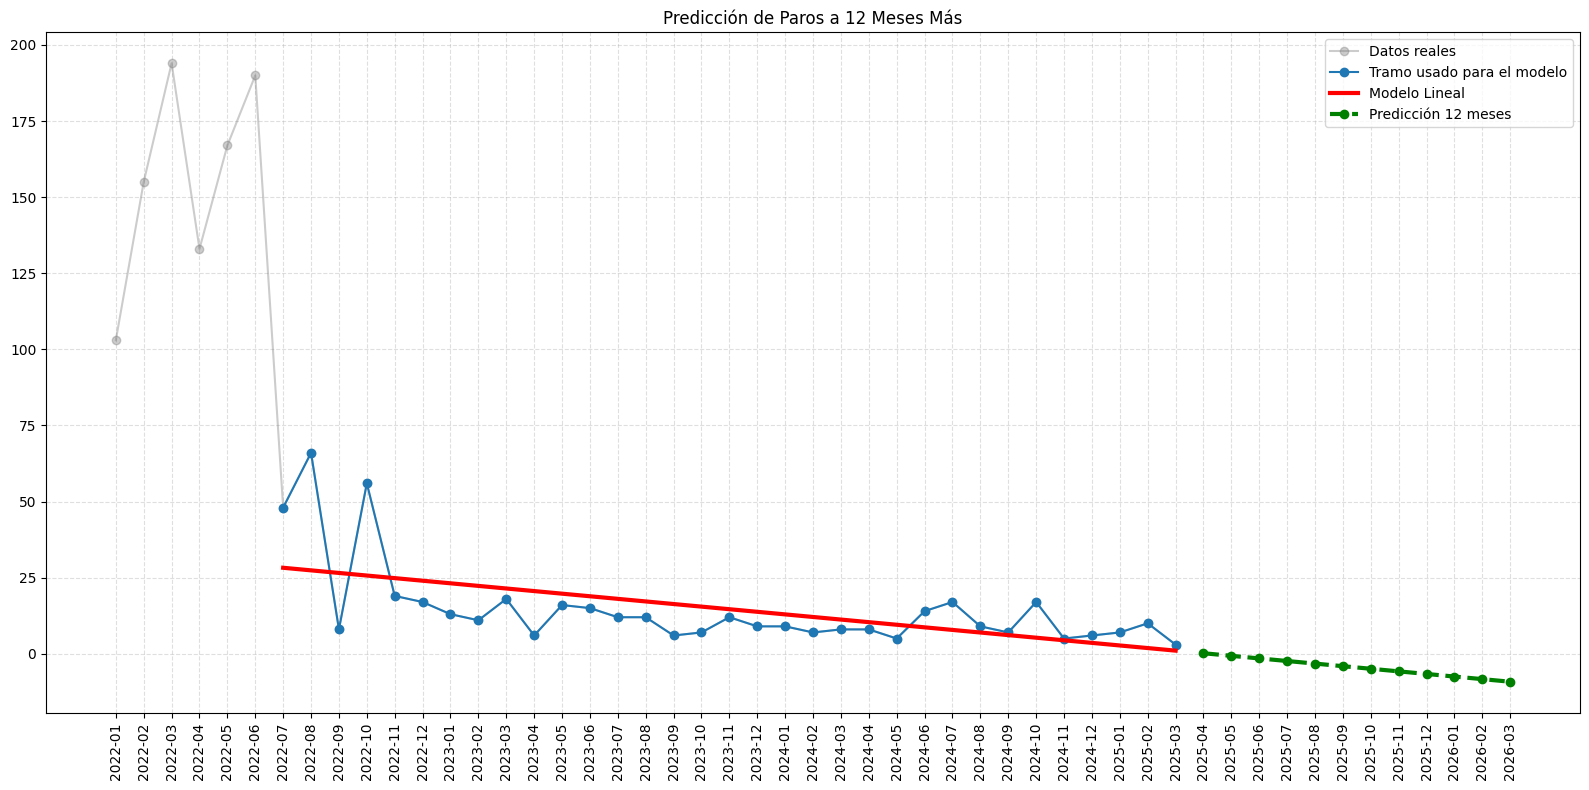

In [13]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# CONFIGURACIÓN DEL TRAMO

t_ini = 6      # Índice temporal inicial
t_fin = 38      # Índice temporal final
max_ctx = t_fin # Contexto hasta este índice

#1. Filtrado y preparación del DataFrame

df_paros = df[df['PARO'] == 1].copy()
df_paros = df_paros.dropna(subset=['FECHA'])
df_paros['FECHA'] = pd.to_datetime(df_paros['FECHA'])

# Agrupar por AÑO-MES
paros_mensuales = (
    df_paros
    .groupby([
        df_paros['FECHA'].dt.year.rename("AÑO"),
        df_paros['FECHA'].dt.month.rename("MES")
    ])
    .size()
    .reset_index(name="FRECUENCIA")
    .sort_values(['AÑO', 'MES'])
    .reset_index(drop=True)
)

# Crear índice temporal
paros_mensuales['TIEMPO'] = np.arange(len(paros_mensuales))

# VALIDACIÓN DEL TRAMO

if t_ini < 0 or t_fin >= len(paros_mensuales):
    raise ValueError(f"El tramo t={t_ini}..{t_fin} está fuera del rango disponible (0..{len(paros_mensuales)-1})")

# 2. Selección del tramo para regresión

mask = paros_mensuales['TIEMPO'].between(t_ini, t_fin)
pm_sub = paros_mensuales.loc[mask].copy()

# Reindexar tiempo del tramo para el modelo
pm_sub['TIEMPO_SUB'] = np.arange(len(pm_sub))

# Variables del modelo
X = pm_sub[['TIEMPO_SUB']]
y = pm_sub['FRECUENCIA']

modelo = LinearRegression().fit(X, y)
pm_sub['PREDICCION'] = modelo.predict(X)


ctx = paros_mensuales.loc[paros_mensuales['TIEMPO'] <= max_ctx].copy()

# ============================================
# PREDICCIÓN A 12 MESES (fragmento simplificado)
# ============================================

meses_futuros = 12

# Reentrenar modelo con el tramo ya definido
pm_sub = paros_mensuales.loc[
    paros_mensuales['TIEMPO'].between(t_ini, t_fin)
].copy()

pm_sub['TIEMPO_SUB'] = np.arange(len(pm_sub))

X = pm_sub[['TIEMPO_SUB']]
y = pm_sub['FRECUENCIA']
modelo = LinearRegression().fit(X, y)

# Índices futuros
ultimo_t = paros_mensuales['TIEMPO'].max()
futuro_tiempo = np.arange(ultimo_t + 1, ultimo_t + meses_futuros + 1)
futuro_sub = np.arange(len(pm_sub), len(pm_sub) + meses_futuros)

# Predicción
pred_futuro = modelo.predict(futuro_sub.reshape(-1, 1))

# Construcción del DataFrame futuro
df_fut = pd.DataFrame({
    'TIEMPO': futuro_tiempo,
    'PREDICCION': pred_futuro
})

# Generación de año-mes futuros
a = int(paros_mensuales.iloc[-1]['AÑO'])
m = int(paros_mensuales.iloc[-1]['MES'])
anos = []
meses = []

for _ in range(meses_futuros):
    m += 1
    if m > 12:
        m = 1
        a += 1
    anos.append(a)
    meses.append(m)

df_fut['AÑO'] = anos
df_fut['MES'] = meses


# Graficar prediccion a 12 meses junto con regecion lineal desde el ano 2022

plt.figure(figsize=(16,8))

# Datos reales
plt.plot(paros_mensuales['TIEMPO'], paros_mensuales['FRECUENCIA'],
         marker='o', color='gray', alpha=0.4, label='Datos reales')

# Tramo analizado
plt.plot(pm_sub['TIEMPO'], pm_sub['FRECUENCIA'],
         marker='o', color='C0', label='Tramo usado para el modelo')

# Tendencia del modelo
plt.plot(pm_sub['TIEMPO'], modelo.predict(X),
         color='red', linewidth=3, label='Modelo Lineal')

# Predicción futura
plt.plot(df_fut['TIEMPO'], df_fut['PREDICCION'],
         marker='o', linestyle='--', color='green', linewidth=3,
         label='Predicción 12 meses')

# Etiquetas rotadas 90°
ticks = list(paros_mensuales['TIEMPO']) + list(df_fut['TIEMPO'])
labels = (
    [f"{a}-{m:02d}" for a, m in zip(paros_mensuales['AÑO'], paros_mensuales['MES'])] +
    [f"{a}-{m:02d}" for a, m in zip(df_fut['AÑO'], df_fut['MES'])]
)

plt.xticks(ticks, labels, rotation=90, fontsize=10)

plt.grid(True, linestyle="--", alpha=0.4)
plt.title("Predicción de Paros a 12 Meses Más")
plt.legend()
plt.tight_layout()
plt.show()

# Se omiten los primeros 7 meses ya que es el momento de arranque donde existen multiples
#  paros de produccion hasta un periodo de estabilizacion



